# Temperature sensor generator configurable schematic from OpenFASOC as code using [Schemdraw](https://schemdraw.readthedocs.io/en/stable/)
```
Copyright 2022 OpenFASOC team.
SPDX-License-Identifier: Apache-2.0
```


## Install Schemdraw

In [ ]:
%pip install schemdraw

## Code to draw schematics

Code starts here. This notebook uses Schemdraw python package to draw schematics of temperature sensor generator. There are two parameters, **n_header and n_inverter**, which configure the temperature sensor generator. One can modify them in the last cell of this notebook. 

In [ ]:
import schemdraw
import schemdraw.logic as logic
import schemdraw.elements as elm
import schemdraw.flow as flow

In [ ]:
#  Splitcontrol level converter 
def slc():
    with schemdraw.Drawing(show=False) as d:
        # left half
        nfet1 = d.add(elm.NFet().left())
        d.move(0, d.unit*(0.5))
        pfet1 = d.add(elm.PFet().right())
        d += elm.Wire().at(nfet1.source).to(pfet1.drain)
        d.move(0, d.unit)
        pfet2 = d.add(elm.PFet().right())
        d += elm.Wire("-|").at(nfet1.source).to(pfet1.gate)
        inb_left = d.add(elm.Dot().at(nfet1.gate).label("INB","top"))

        # center
        vdd = d.add(elm.Line().right().at(pfet2.source).length(d.unit*0.5))
        d += elm.Dot()
        d += elm.Vdd().label("VDD","top")
        d += elm.Line().right().length(d.unit*0.5)

        # right half
        d.move(0, d.unit*(-1.0))
        nfet2 = d.add(elm.NFet().right())
        d.move(0, d.unit*(0.5))
        pfet3 = d.add(elm.PFet().left())
        d += elm.Wire().at(nfet2.drain).to(pfet3.source)
        d.move(0, d.unit*(0.5))
        pfet4 = d.add(elm.PFet().left())
        d += elm.Wire("-|").at(nfet2.drain).to(pfet3.gate)
        in_right= d.add(elm.Dot().at(nfet2.gate).label("IN","right"))

        # other connections
        d += elm.Wire("-").at(pfet1.gate).to(pfet4.gate)
        d += elm.Wire("-").at(pfet2.gate).to(pfet3.gate)

        # bottom
        d.move(0, d.unit*(-1))
        gnd = d.add(elm.Dot())

        d += elm.Ground().label("GND","bottom")
        d += elm.Wire("-|").to(nfet2.source)
        d += elm.Wire("-|").to(nfet1.drain).at(gnd.center)

        # inverter
        d.move(d.unit*(2.5),0)
        d += elm.Ground().label("GND","bottom")
        nfet3 = d.add(elm.NFet().left())
        pfet5 = d.add(elm.PFet())
        d += elm.Vdd().label("VDD","top")
        out = d.add(elm.Dot().at(nfet3.source).label("OUT","right"))

        # bridge
        d += elm.Wire("-|").at(pfet3.source).to(nfet3.gate)
        d += elm.Wire("-|").at(pfet3.drain).to(pfet5.gate)

        # wiring extensions
        d += elm.Line().at(in_right.center).down()
        d += elm.Line().left().length(d.unit*(1.9))
        d += elm.Line().up().length(d.unit*(0.5))
        d += elm.Line().left().length(d.unit*(0.5))
        d += elm.Dot().label("IN")

        out_line = d.add(elm.Line().at(out.center).right().length(d.unit*(0.5)))
        out_dot = d.add(elm.Dot())
        d += elm.Line().down().length(d.unit*(1.5))
        d += elm.LineDot().at(out_dot.center).right().label("CLKOUT","top")

        d += elm.Line().at(inb_left.center).left().length(d.unit*(0.5))


        return elm.ElementDrawing(d)


In [ ]:
# Header cell - design A
# This generates super-cut-off leakage and low RO frequency, which trades off higher quantization noise for 
# lower power

def header_a(n_header):
    with schemdraw.Drawing(show=False) as d:
        for i in range(0,n_header):
            nfet1 = d.add(elm.NFet().left())
            d += elm.Ground().at(nfet1.gate)
            d.move(d.unit*(0.455),d.unit*(0.25))
            nfet2 = d.add(elm.NFet().left())
            if (i != (n_header-1)):
                d.move(d.unit*(1.0),d.unit*(-1.5))
                d += elm.Line().at(nfet2.source).right().length(d.unit*(0.65))
            short = d.add(elm.Wire("-|").at(nfet1.gate).to(nfet2.gate))
            d.move(d.unit*(1.1),d.unit*(-0.75))
            if (i == (n_header-1)):
                d.move(d.unit*(-0.645),d.unit*(1))
                d += elm.Vdd().label("VDD","top")
                d.move(0,d.unit*(-1))
                end = d.add(elm.Dot())
                d += elm.Line().left().length((n_header-1)*2-0.3)
        d += elm.Line().at(end.center).down().length(0.8)
        d += elm.Dot().label("VDDL","right")
        return elm.ElementDrawing(d)


In [ ]:
# Header cell - design B
# This generates cut-off leakage and higher RO frequency, which trades off higher power for lower
# quantization noise.

def header_b(n_header):
    with schemdraw.Drawing(show=False) as d:
        for i in range(0,n_header):
            nfet1 = d.add(elm.NFet().left())
            d += elm.Line().at(nfet1.gate).length(d.unit*(0.2)).down()
            ptn = d.add(elm.Dot())
            d.move(d.unit*(0.455),d.unit*(0.3))
            nfet2 = d.add(elm.NFet().left())
            d += elm.Wire("-|").at(ptn.center).to(nfet1.drain)
            d += elm.Line().down().length(d.unit*(0.1))
           
            if (i != (n_header-1)):
                d += elm.Line().right().length(d.unit*(0.3))
                d += elm.Line().right().length(d.unit*(0.5))
                d.move(d.unit*(-0.8),d.unit*(0.95))
                d += elm.Line().right().length(d.unit*(0.3))
                # d += elm.Dot().label("x")
                d += elm.Line().right().length(d.unit*(0.5))
                d.move(d.unit*(1.0),d.unit*(-1.5))
                d += elm.Line().at(nfet2.source).right().length(d.unit*(0.65))
                # d += elm.Dot().label("y")
            else:
                d.move(0,d.unit*(0.95))
                d += elm.Vdd().label("VDD","top")
            
            short = d.add(elm.Wire("-|").at(nfet1.gate).to(nfet2.gate))
            if (i != (n_header-1)):
                d.move(d.unit*(1.2),d.unit*(-0.6))
                # d += elm.Dot().label("z")
            else:
                d.move(d.unit*(0.45),d.unit*(-0.7))
                end = d.add(elm.Dot())

        d += elm.Line().at(end.center).down().length(0.8)
        d += elm.Dot().label("VDDL").down()
        return elm.ElementDrawing(d)   

In [ ]:
# Ring Oscillator (RO) works as the temperature sensing element and employ leakage-based temperature dependency.

def ring_oscillator(n_inv):
    with schemdraw.Drawing(show=False) as d:

        #Nand logic
        nand = d.add(logic.logic.Nand())
        d.move(d.unit*(-0.25),d.unit*(0.17))
        d += elm.Line().up().length(d.unit*(0.4))
        d += elm.Line().right().length(d.unit*(0.5))

        d.move(d.unit*(-0.3),d.unit*(-0.57))
        d += elm.Line().right().length(d.unit*(0.5))

        # Inverter chain based on the count
        for i in range(0,n_inv):
            d += logic.logic.Not().right()
            d.move(d.unit*(-0.48),d.unit*(0.55))
            d += elm.Line().down().length(d.unit*(0.5))

            d.move(0,d.unit*(0.52))
            d += elm.Line().right().length(d.unit*(0.5))

            # connect the power net of Nand to the first inverter
            if i == 0:
                d.move(d.unit*(-0.3),0)    
                d += elm.Line().left().length(d.unit*(1))
                d.move(d.unit*(1.3),0)    
            d += elm.Line().right().length(d.unit*(0.5))

            d.move(d.unit*(-0.51),d.unit*(-0.57))

        # Feedback line from the last inverter
        feedback = d.add(elm.Line().down().length(d.unit*(0.5)))
        d.move(d.unit*(0.5),d.unit*(1.05))

        # Connect the power net of last inverter to the prev built inverter chain
        d += elm.Line().down().length(d.unit*(0.5))
        d.move(d.unit*(-0.5),d.unit*(-0.55))


        d.move(0,d.unit*(0.5))

        # Last inverter with feedback
        LNot = d.add(logic.logic.Not().right())
        d.move(0,d.unit*(-0.5))
        d += elm.Wire("-|").to(nand.in2)
        d += elm.Dot()
        return elm.ElementDrawing(d)


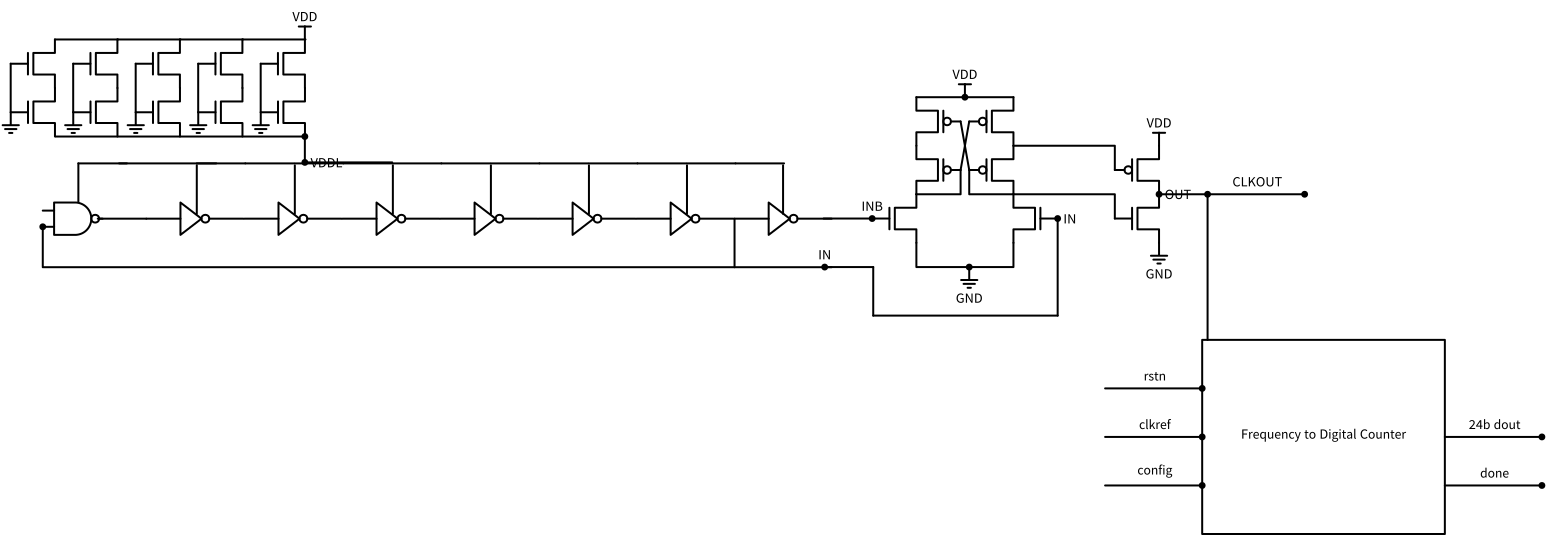

In [5]:
# No of headers and inverters are the varying parameters for the temperature sensor from OpenFASOC
# -------
n_header=5
n_inv=6
# -------

with schemdraw.Drawing() as d:
    header_cell = d.add(header_a(n_header))
    d += elm.Line().length(d.unit*(0.9))
    d.move(d.unit*(-3.6),d.unit*(-0.58))
    
    ring_osc_cell = d.add(ring_oscillator(n_inv))
    d.move(d.unit*(9.0),d.unit*(-0.165))
    slc_cell = d.add(slc())

    d.move(d.unit*(2.9),d.unit*(-1.75))

    d += elm.LineDot().label("rstn")
    d.move(d.unit*(-1),d.unit*(-0.5))
    d += elm.LineDot().label("clkref")
    d.move(d.unit*(-1),d.unit*(-0.5))
    d += elm.LineDot().label("config")
    d.move(d.unit*(0),d.unit*(0.5))    
    d += flow.flow.Box(w=d.unit*(2.5),h=d.unit*(2)).label("Frequency to Digital Counter")

    d += elm.LineDot().label("24b dout")
    d.move(d.unit*(-1),d.unit*(-0.5))
    d += elm.LineDot().label("done")